In [210]:
%matplotlib inline

In [211]:
%%bash
pip install gym[classic_control]

In [212]:
'''
Deep Q-Learning 
Gym - Cartpole environment
'''
'''imports'''

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 

import sys
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import namedtuple, deque

debug = False

'''Hyperparameters'''
MEM_SIZE = 10000
UPDATE_TARG_FREQ = 10
GAMMA = 0.99
BATCH_SIZE = 32
BETA = 1.0  # Huber loss
EPISODES = 500

EPS_MAX = 0.9
EPS_DECAY = 200
EPS_MIN = 0.05

def log(*args):
    if debug:
        print(*args)

log(gym.__version__)
from gym.utils.env_checker import check_env


In [213]:
'''Environment setup'''
if gym.__version__ < '0.26':
    env = gym.make('CartPole-v0', render_mode="rgb_array")
else:
    env = gym.make('CartPole-v0', render_mode="rgb_array")

check_env(env)

log(env)
log(env.action_space)
log(env.observation_space)

is_jupyter = 'inline' in matplotlib.get_backend()
if is_jupyter:
    from IPython import display
plt.ion()

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

log(device)

/home/mekasaimukund/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/mekasaimukund/.local/lib/python3.10/site-packages/gym/utils/env_checker.py:277: UserWarning: WARN: The environment (<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v0>>>>>) is different from the unwrapped version (<CartPoleEnv<CartPole-v0>>). This could effect the environment checker as the environment most likely has a wrapper applied to it. We recommend using the raw environment for `check_env` using `env.unwrapped`.
  logger.warn(


/home/mekasaimukund/miniconda3/envs/nn/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


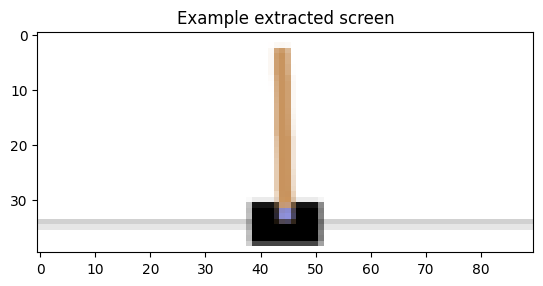

In [214]:
import torchvision.transforms as T
from PIL import Image

# extraction and processing of cartpole snapshot
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.Resampling.BICUBIC),
                    T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    log('yes')
    screen = env.render().transpose((2, 0, 1))
    # screen = env.render()
    # print(env.render())
    log('ok')
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    log(screen_height, screen_width)
    
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    # log(cart_location, screen_width, view_width)
    
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)

    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)

state =  env.reset()
log(state)
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [215]:
'''Neural Network for modelling the Q function'''
'''
super().__init__() - initialises the parent class, nn.Module here, 
which is a base class for all neural network modules

nn.conv2d(in_channel, out_channel, kernel_size, stride, padding)
in_channel: number of channels in the input image
out_channel: number of channels produced by the convolution or no of filters
kernel_size: size of the convolving kernels
stride: stride of the convolution
padding: zero-padding added to both sides of the input

nn.BatchNorm2d(num_features)
num_features: number of channels in the input image
batch normalisation: normalises the output of a previous activation layer by
subtracting the batch mean and dividing by the batch standard deviation 
'''
class DQN(nn.Module):
    def __init__(self, ht, wid, output):
        super(DQN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)


        self.head = nn.Linear(32 * 16, output)

    def forward(self, x):
        x = x.to(device)      # moving data to a gpu
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        return self.head(x.view(x.size(0), -1))     # ??        
        # x.view -- reshapes the tensor to a given shape
        # x.view(x.size(0), -1) -- flattening the tensor


In [216]:
Transition = namedtuple('transition', ('s', 'a', 's_next', 'r'))
class Memory(object):
    def __init__(self, capacity):
        self.buffer = deque([], maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    
    def __len__(self):
        return len(self.buffer)

In [217]:
_, _, screen_height, screen_width = get_screen().shape

policy = DQN(screen_height, screen_width, env.action_space.n)    # policy network
target = DQN(screen_height, screen_width, env.action_space.n)   # target network

policy = policy.to(device)     # using gpu
target = target.to(device)

'''
1. target network is occasionally updated with the policy network weights
2. Actions are chosen from target network and based on it, policy network weights 
   are updated in EACH iteration. 
'''
target.load_state_dict(policy.state_dict())    # copying the weights
target.eval()     # setting the target network to evaluation mode


'''
torch.autograd() - automatic differentiation package
used in backpropagation to compute the gradients of the loss function w.r.t. 
the weights of the neural network

target.eval() - sets the module in evaluation mode
evaluation mode: dropout and batch normalization layers are disabled

torch.no_grad() - turn off gradient calculation
detach() - returns a new tensor, detached from the current graph
         - gradient descent turned off for the tensor
         - moves tensor to CPU

'''

optimizer = optim.RMSprop(policy.parameters())    # MSE loss
memory = Memory(MEM_SIZE)                         # memory buffer

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    batch = memory.sample(BATCH_SIZE)
    log(len(batch))
    for i in range(len(batch)):
        log(f"{i}th sample: {batch[i]}")
    
    mask = torch.tensor(tuple(map(lambda s: s is not None, batch.s_next)), device=device, dtype=torch.bool)  # lists all non-final states
    n_s_next = torch.cat([elem for elem in batch.s_next if elem is not None])   # concatenates all non-final states
    
    s = torch.cat(batch.s)
    a = torch.cat(batch.a)
    r = torch.cat(batch.r)

    # Q(s, a)
    q_values = policy(s).gather(1, a)
    # Q(s_next, a_next)
    next_q_values = torch.zeros(BATCH_SIZE, device=device)
    next_q_values[mask] = target(n_s_next).max(1)[0]    # gives optimal q_values
    
    # expected Q values
    expected_q_values = r + GAMMA * next_q_values

    # loss function
    loss_func = nn.SmoothL1Loss()
    loss = loss_func(q_values, expected_q_values)

    '''
    torch.gather(t, 1, torch.tensor([[0, 0], [1, 0]]))
    tensor([[1,  1], [4,  3]])   
    gathers the values at the indices specified in the second argument
    
    x = torch.tensor([1, 2, 3, 4])
    torch.unsqueeze(x, 0) ---- tensor([[ 1,  2,  3,  4]]), new tensor with dimension of size 1 inserted at the specified position
    torch.unsqueeze(x, 1)
    tensor([[ 1],
            [ 2],
            [ 3],
            [ 4]])
    '''

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    for param in policy.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [218]:
step_counter = 0  # for eps-decay in the e-greedy policy
def action_policy(state):
    global step_counter
    
    eps = EPS_MAX + (EPS_MAX - EPS_MIN) * math.exp(-1.0 * step_counter / EPS_DECAY)
    step_counter += 1
    
    if random.random() > eps:       # explore with (1 - eps) prob
        with torch.no_grad():
            return policy(state).max(1)[1].view(1, 1)
            # v.max(1) returns largest column value of each row
            # 2nd arg = 1 returns the index of the max value
            # view(1, 1) reshapes the tensor to a 1x1 tensor
    else:
        return torch.tensor([[random.randrange(env.action_space.n)]], device=device, dtype=torch.long)

In [219]:
episode_durations = []

def plot_graph():
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)

    plt.title('Results')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.show()


/home/mekasaimukund/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Done


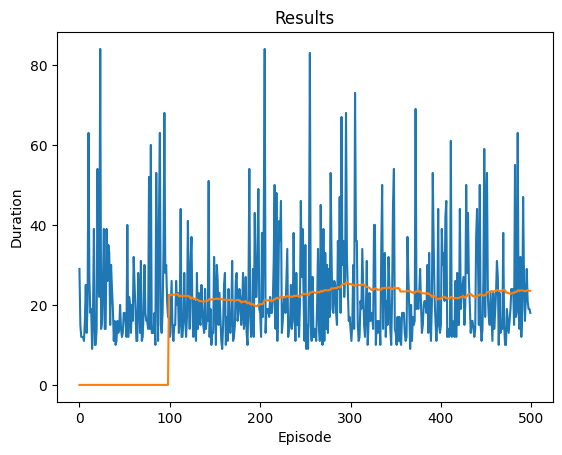

In [220]:
for ep in range(EPISODES):
    # initialisation
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    iter = 0
    while True:
        action = action_policy(state)
        _, reward, done, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
        
        # replay memory store
        memory.push(state, action, next_state, reward)
        state = next_state

        # optimize policy network
        optimize_model()

        # copy wts to target
        if iter % UPDATE_TARG_FREQ == 0:
            target.load_state_dict(policy.state_dict())

        if done:
            episode_durations.append(iter + 1)
            break

        iter += 1

print('Done')
plot_graph()

In [221]:
'''experimental cell'''
%%script false --no-raise-error       # comment out the line to run
x = torch.tensor([1, 2, 3, 4])
print(torch.unsqueeze(x, 0).size()) 
print(torch.unsqueeze(x, 1).size())

print(torch.unsqueeze(x, 0)) 
print(torch.unsqueeze(x, 1))

x = torch.tensor([[1, 2], [3, 4]])
print(torch.unsqueeze(x, 0).size()) 
print(torch.unsqueeze(x, 1).size())
print(torch.unsqueeze(x, 2).size())


print(torch.unsqueeze(x, 0)) 
print(torch.unsqueeze(x, 1))
print(torch.unsqueeze(x, 2))


UsageError: Line magic function `%%script` not found.
